In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product
import torch.nn.functional as F

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [2]:
from utils import *
from embed import *

models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [3]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t % (T//10) == 0 or (t == T-1):
            ts.append(t)
ts = np.array(ts)
tmap = {i:ts[i] for i in range(len(ts))}
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
N = len(pts)

## Bhat vs InPCA

In [70]:
loc = 'inpca_results'
fn = 'yh_new_interpolate_with_avg'
w = th.load(os.path.join(loc,'w_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

In [89]:
rmean = w.mean(1, keepdims=True)
w_ = w - rmean
cmean = w_.mean(0, keepdims=True)
w_ = w_ - cmean
# np.allclose(w_, l@w@l)

In [90]:
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l 
n = len(w)
r = proj_(w, n, 500)

Projecting


In [4]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200, 400], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, keys=['yh'], drop=False, probs=True)

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 3600


In [5]:
d = avg_model(d, groupby=['m', 'opt', 't', 'bs'], probs=True, get_err=True, keys=['yh'],
              update_d=True, compute_distance=False, dev='cuda')['d']

In [6]:
d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg', 'bs'], keys=['yh'], dev='cuda')

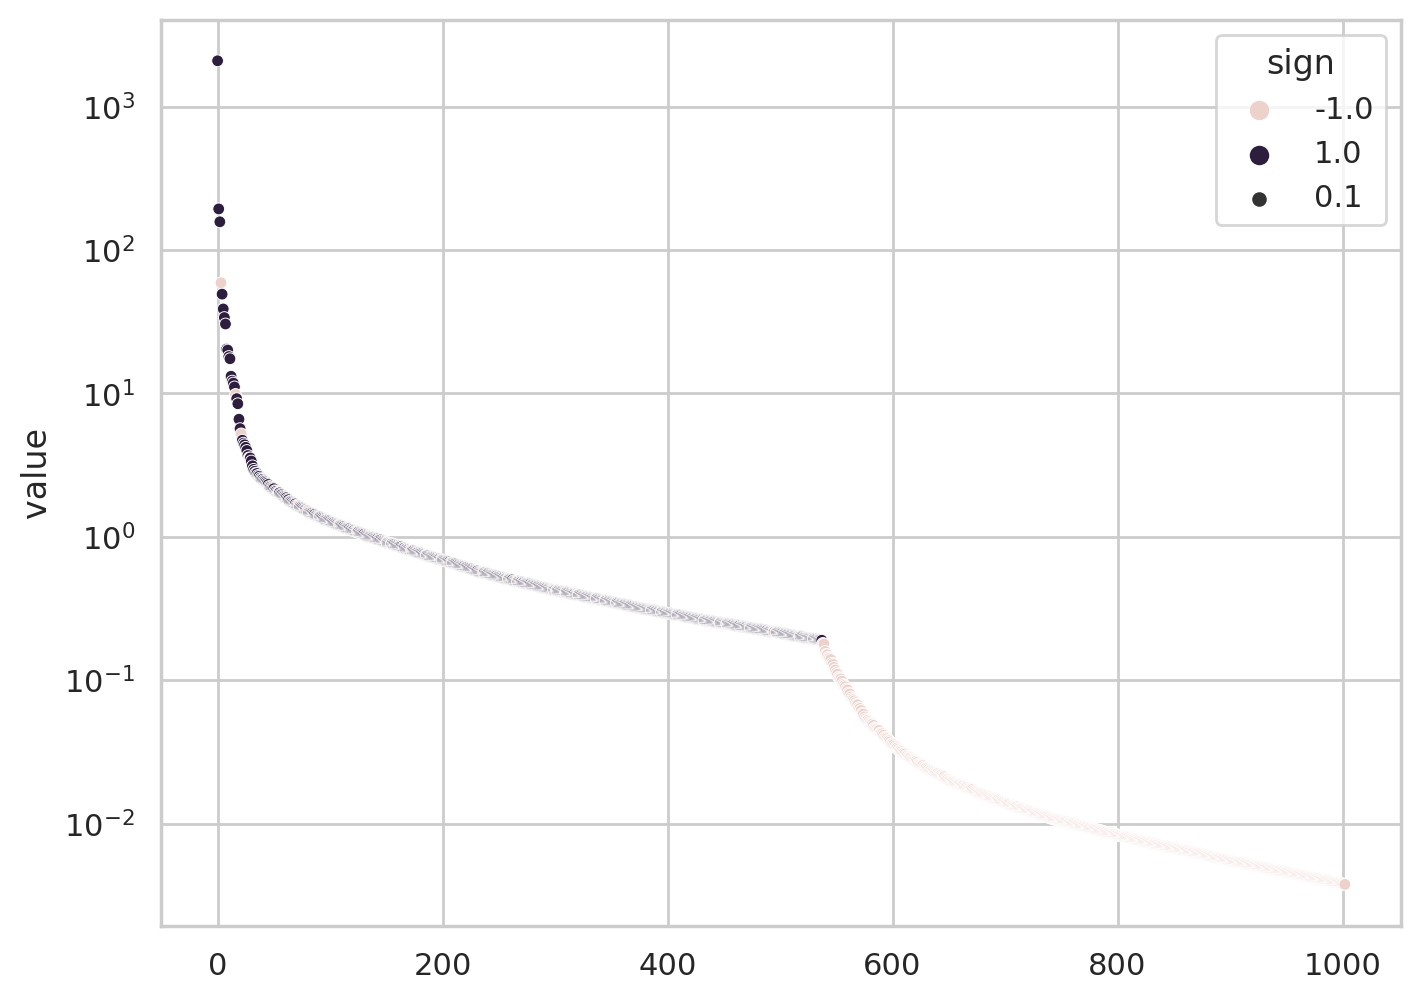

In [6]:
df = pd.DataFrame(np.vstack([np.abs(r['e']), np.sign(r['e'])]).T, columns=['value', 'sign'])
# plt.plot(df['value'])
ax = sns.scatterplot(data=df, x=df.index, y='value', hue='sign', size=0.1)
ax.set_yscale('log')

In [107]:
from distance import dbhat, dinpca

dists = []
k = 'yh'
m = models[0]
o = opts[0]
seeds = dc['seed'].unique()

avg_fnorm = []
for ne in np.concatenate([np.arange(10, 50, 10), np.arange(50, 500, 100), np.arange(500,1000, 200)]):
    for s1 in range(len(seeds)):
        for s2 in range(s1+1, len(seeds)):
            ne = int(ne)
            i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s1]}")
            i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s2]}")
            di = dinpca(th.Tensor(r['xp'][i1, :ne]), th.Tensor(r['xp'][i2, :ne]), th.Tensor(np.sign(r['e'][:ne])))
#             di = di + th.Tensor(cmean[:, i1]).cuda() + th.Tensor(rmean[i2, :]).cuda()
#             db = dbhat(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])))
            db = th.Tensor(w)[:, i1][i2].to(dev)
            avg_fnorm.append(dict(fnorm=th.norm(di-db).item(), ne=ne, label=(seeds[s1], seeds[s2])))
    #         dists.append(dict(dist=di.cpu(), distf='inpca', s1=seeds[s1], s2=seeds[s2]))
    #         dists.append(dict(dist=db.cpu()**2, distf='bhat', s1=seeds[s1], s2=seeds[s2]))
dists = pd.DataFrame(dists)

<AxesSubplot:xlabel='ne', ylabel='fnorm'>

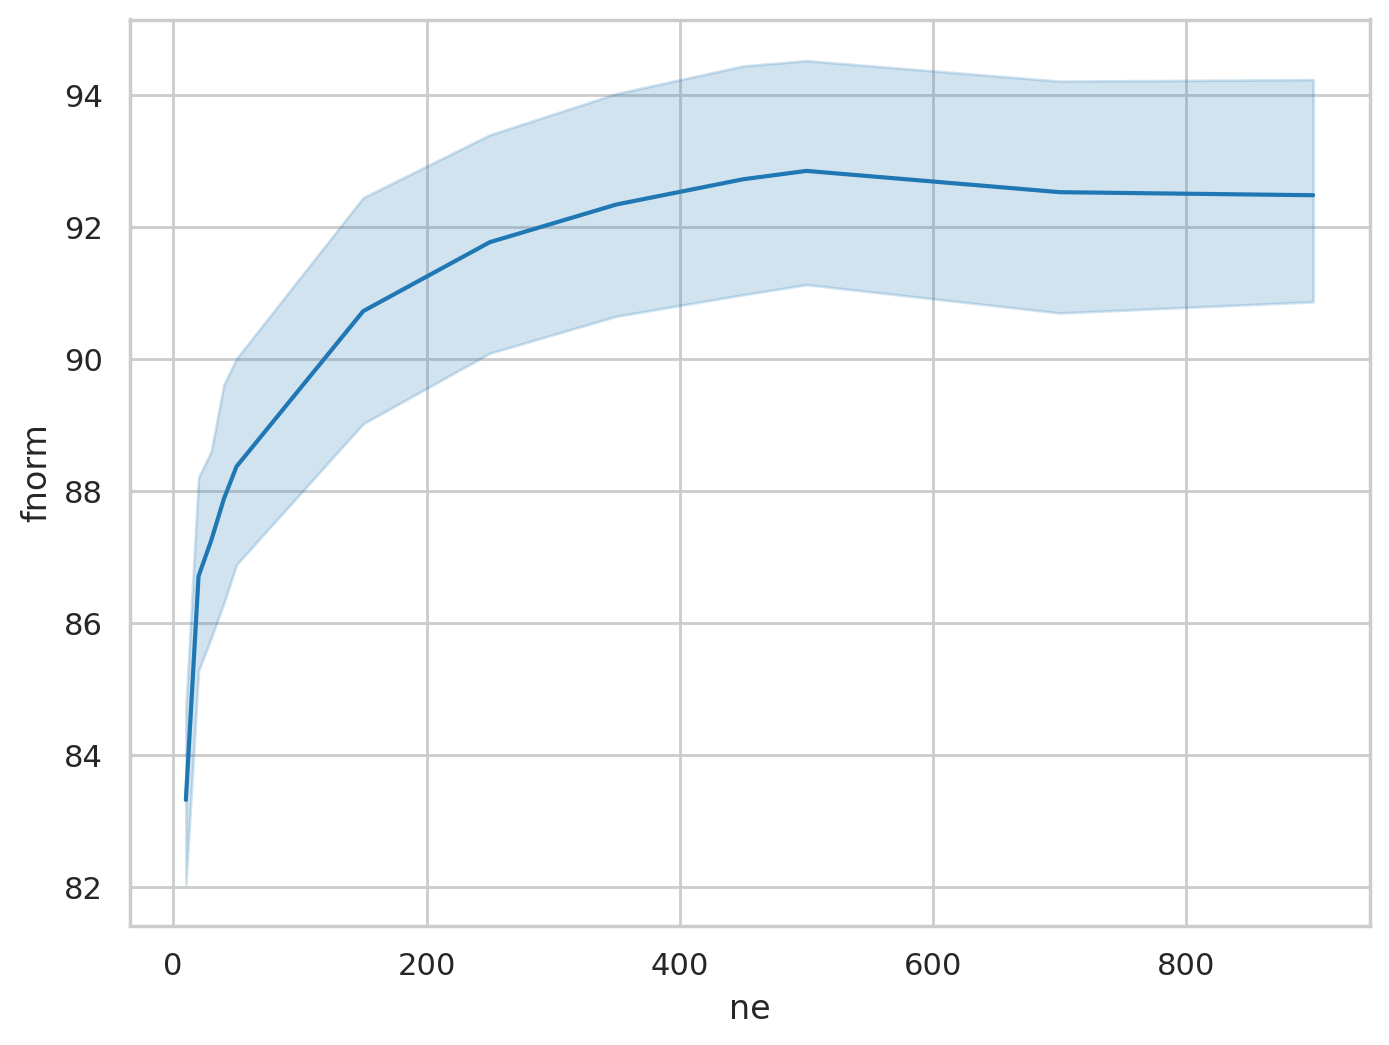

In [108]:
df = pd.DataFrame(avg_fnorm)
sns.lineplot(data=df, x='ne', y='fnorm')

## Distance to avg

In [24]:
dt =( pts[1:] - pts[:1] ) /T

In [42]:
dists = []
for s in np.concatenate([[0], np.arange(0.05, 0.5, 0.05)]):
    k = 'yh'
    o = opts[0]
    m = models[0]
    i1 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs==200 & avg==True")
    for seed in d['seed'].unique():
        if seed < 0:
            continue
        i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs==200& seed=={seed}")
        kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values)), 
                     dys=th.ones(95).cuda(), s=s)
        if s == 0:
            kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values)), 
                         use_min=True)
        for i in range(N):
            dists.append(dict(dist=kdist[i].item(),
                              m=m, opt=o, 
                              t=pts[i], key=k, seed=seed, s=s))

Text(0.5, 1.0, 'weight $\\propto exp(-d^2/2s^2) * dy$')

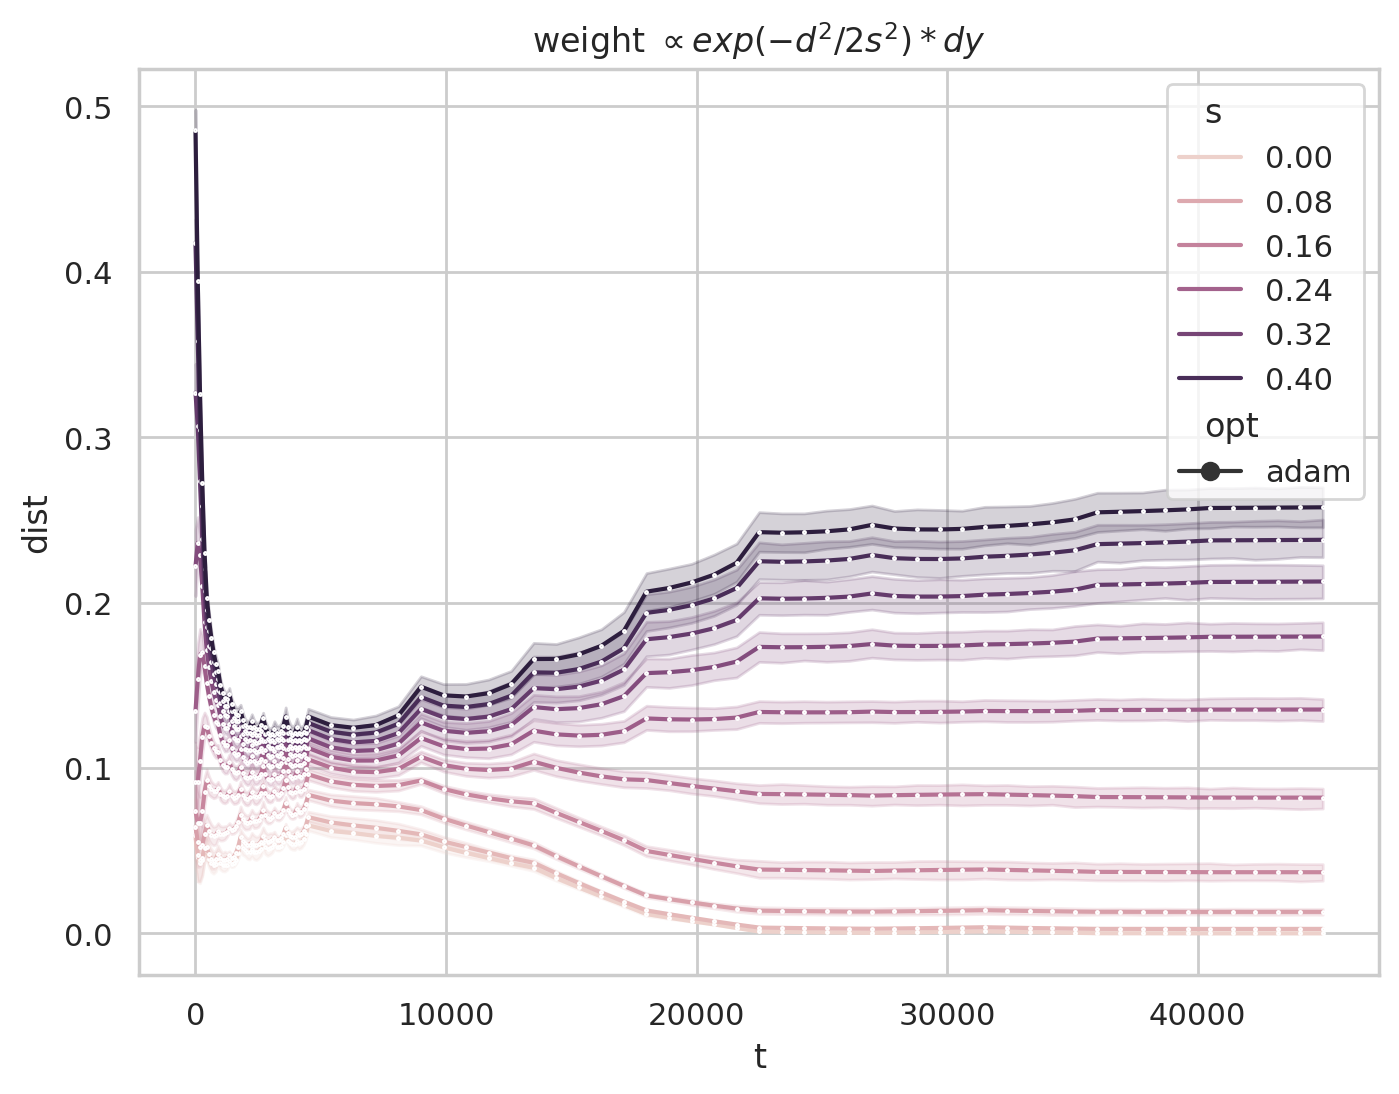

In [41]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weight $\propto exp(-d^2/2s^2) * dy$')

Text(0.5, 1.0, 'weight $\\propto exp(-d^2/2s^2) * dt$')

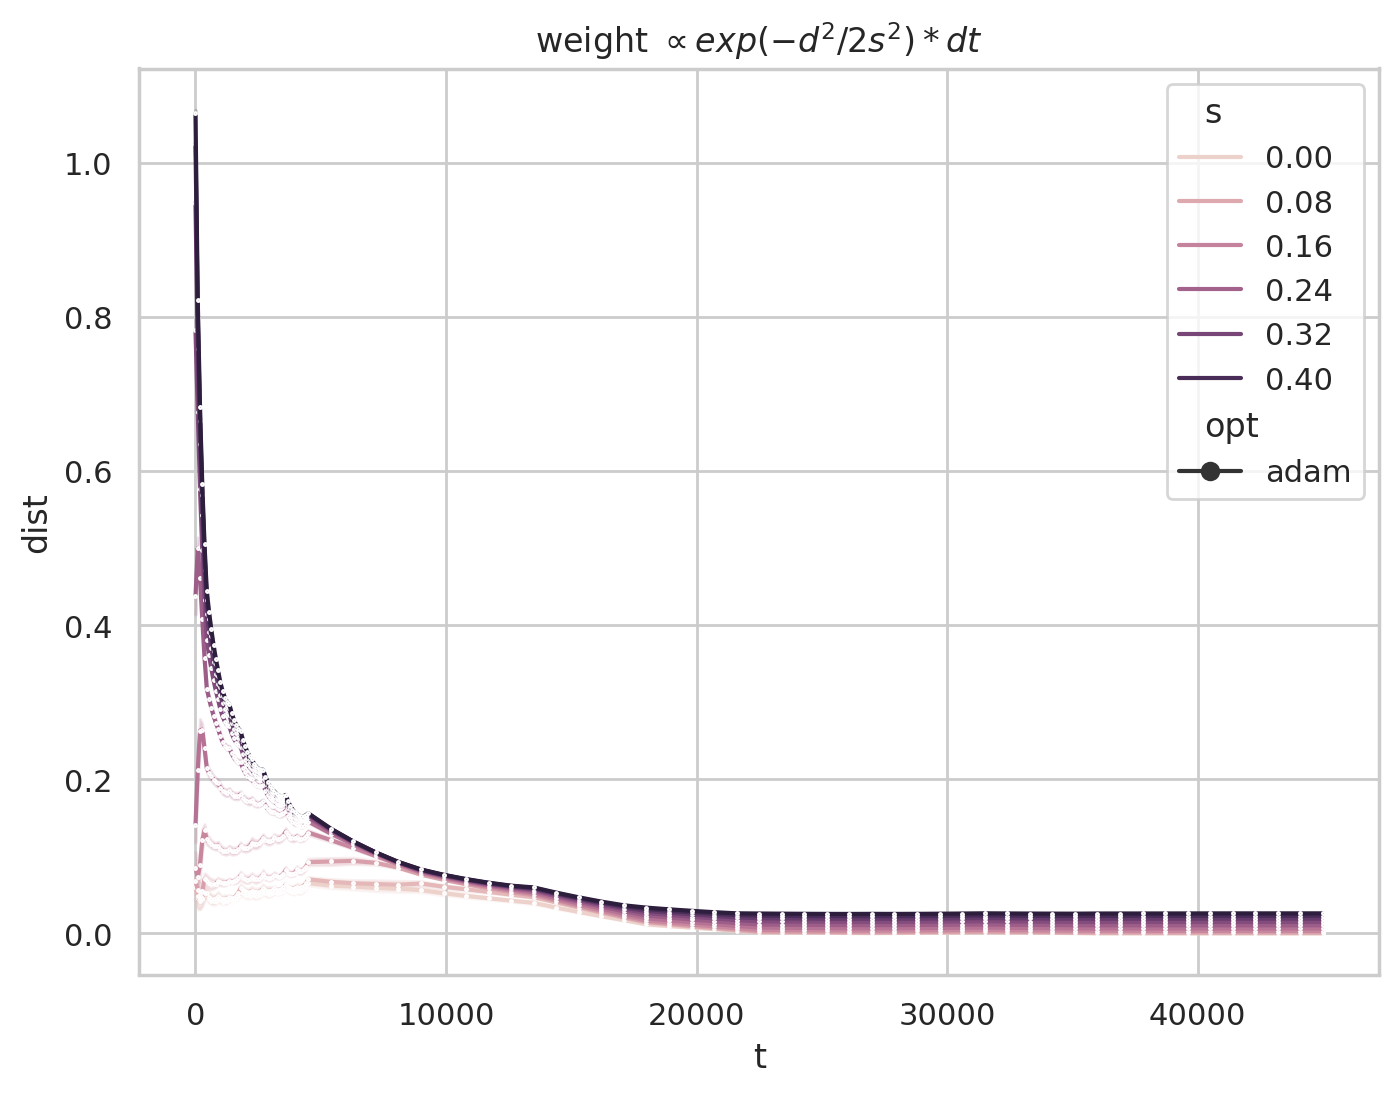

In [39]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weight $\propto exp(-d^2/2s^2) * dt$')

Text(0.5, 1.0, 'weight $\\propto exp(-d^2/2s^2)$')

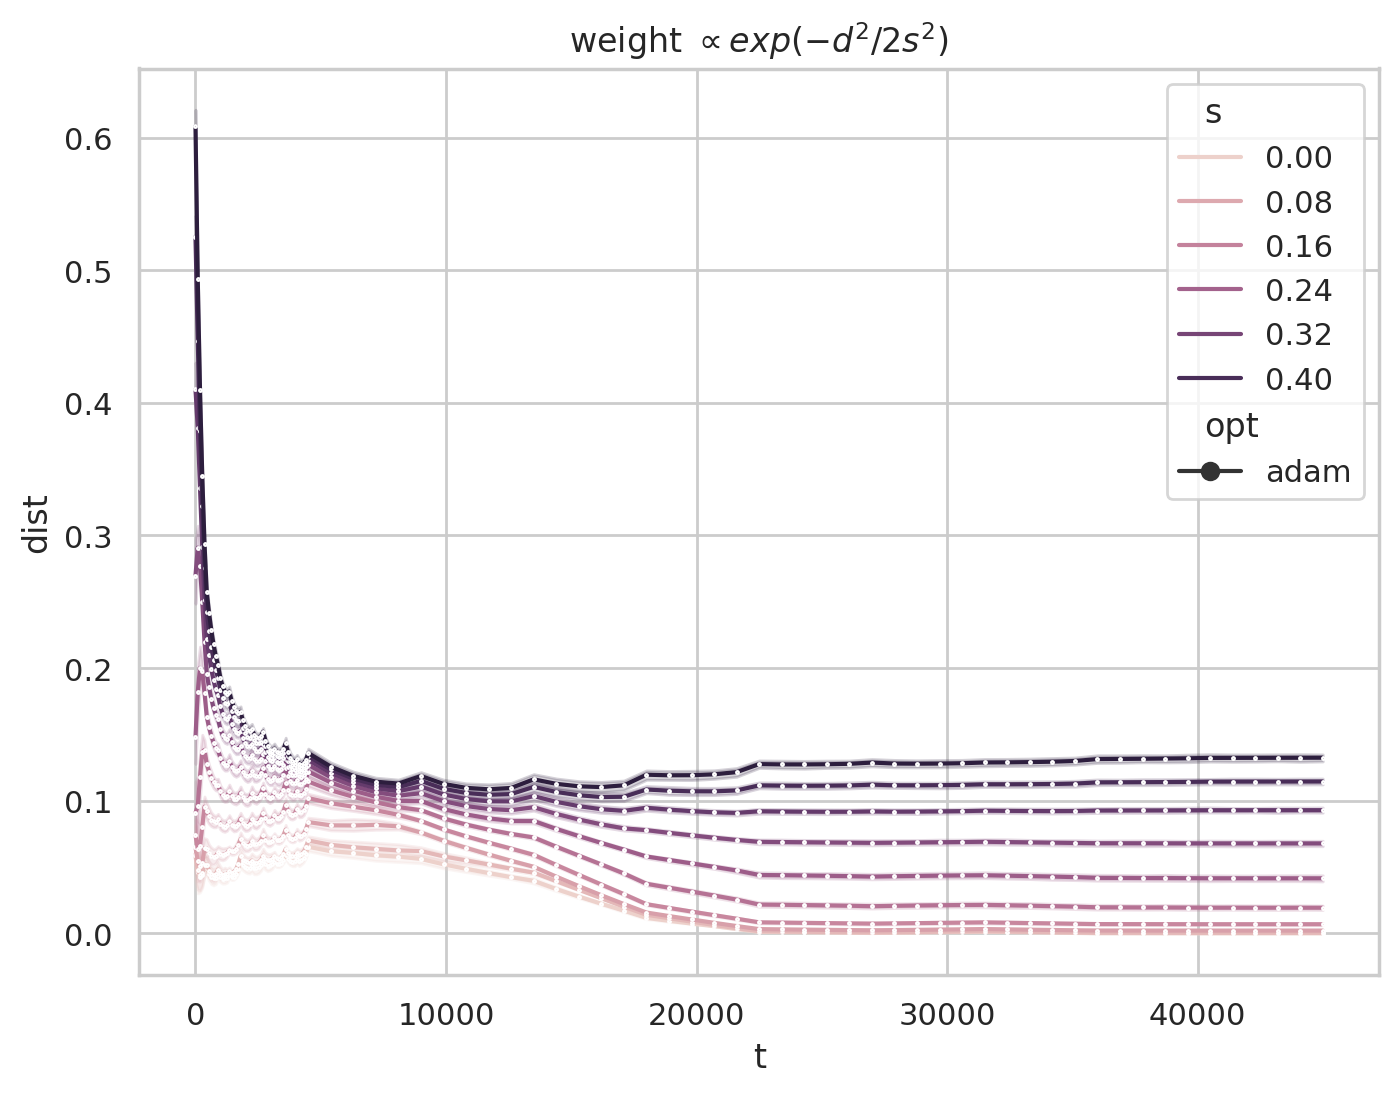

In [43]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weight $\propto exp(-d^2/2s^2)$')

In [8]:
dists = []
k = 'yh'
for bs in [200, 400]:
    for o in opts:
        for m in models:
            
            i1 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs=={bs} & avg==True")
            for seed in d['seed'].unique():
                if seed < 0:
                    continue
                i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs=={bs} & seed=={seed}")
                kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), 
                             th.Tensor(np.stack(d.iloc[i2][k].values)), s=0.05)
                for i in range(N):
                    dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                      t=pts[i], key=k, seed=seed, s=0.05, bs=bs))

Text(0.5, 1.0, 'distance to average model, bs==200, s==0.05')

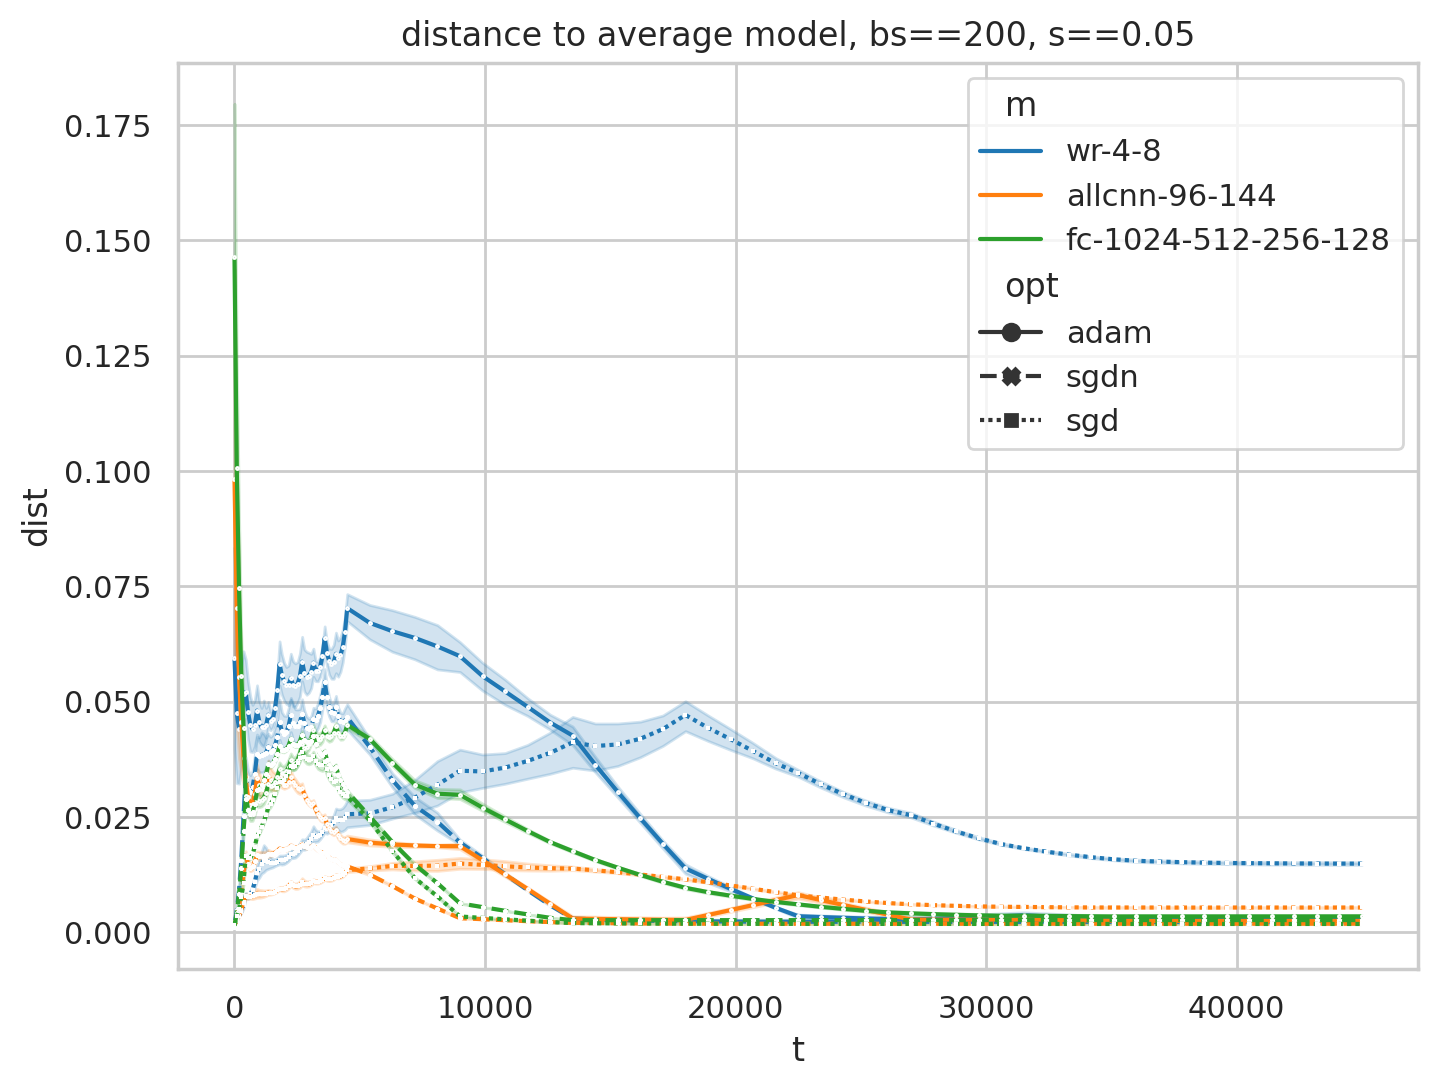

In [9]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"bs==200")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model, bs==200, s==0.05')

Text(0.5, 1.0, 'distance to average model, bs==200')

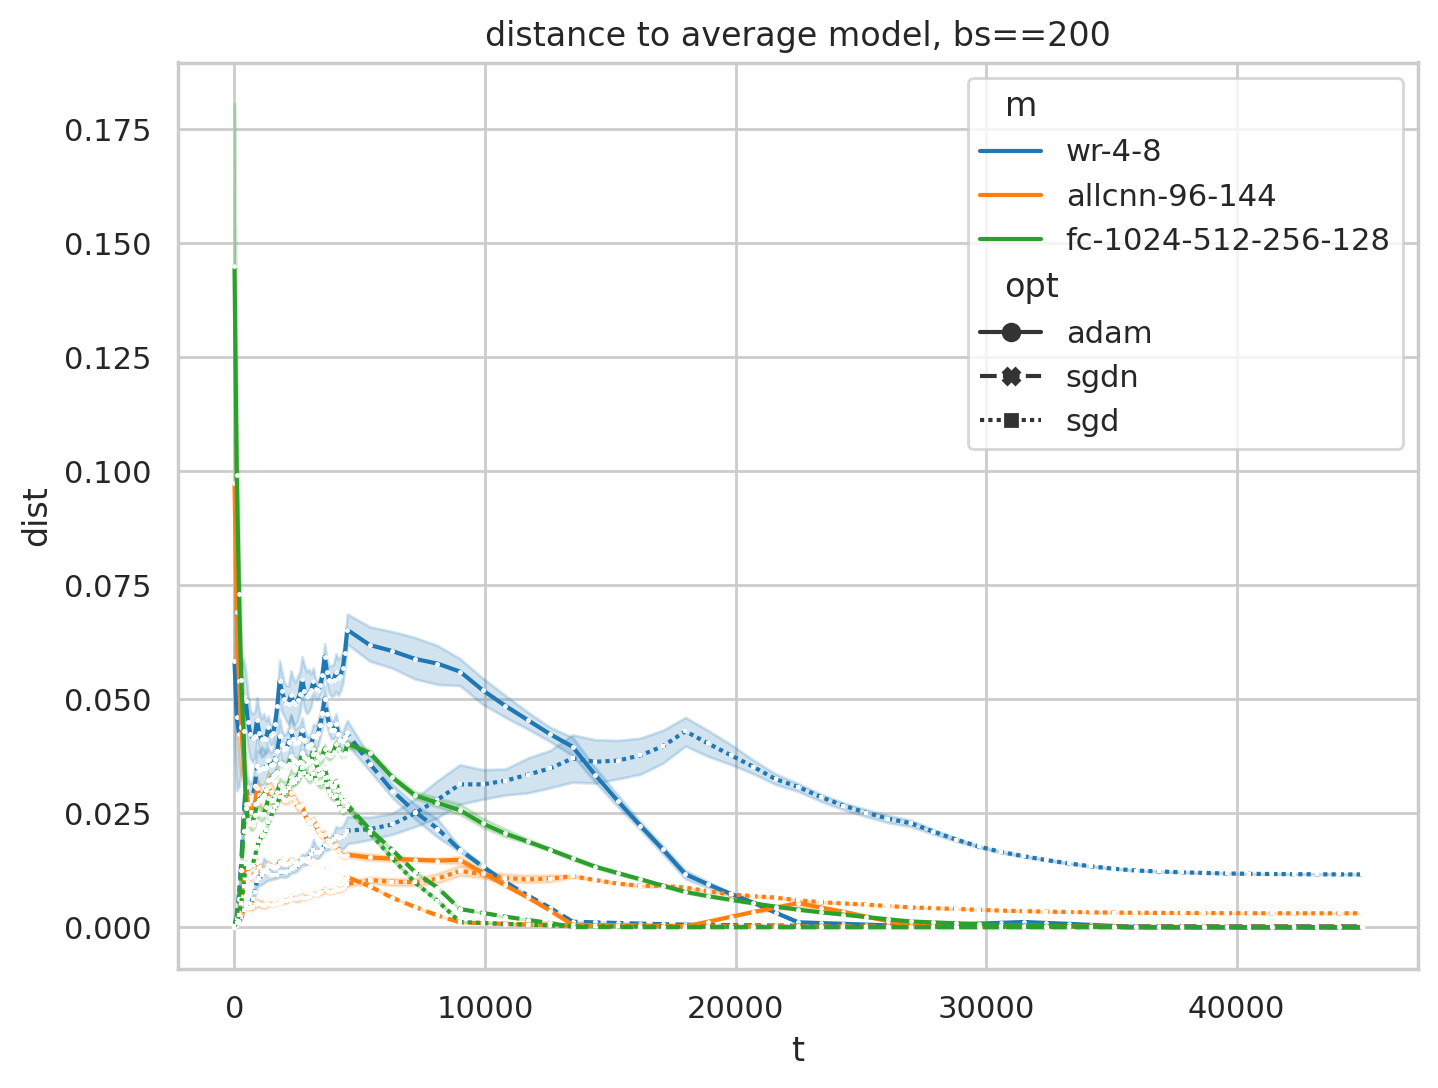

In [23]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"bs==200")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model, bs==200')

Text(0.5, 1.0, 'distance to average model, bs=400')

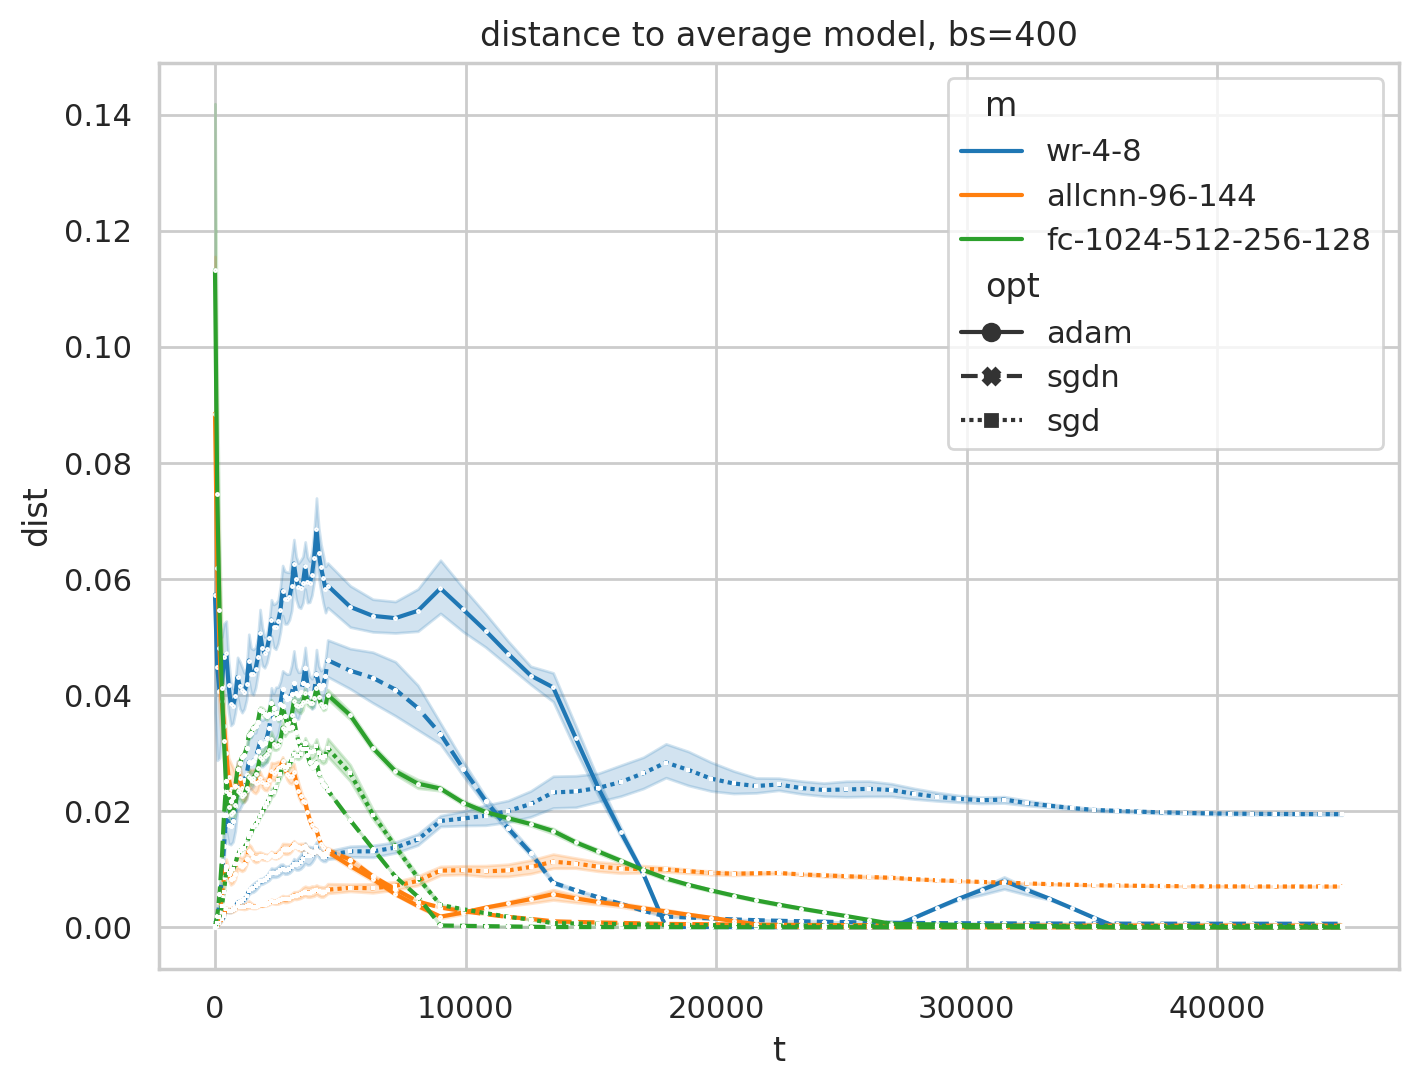

In [22]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"bs==400")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model, bs=400')

## Pairwise Distance

In [40]:
d = load_d(loc, cond={'bs':[200, 400], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, drop=True, probs=True)

d = avg_model(d, groupby=['m', 'opt', 't', 'bs'], probs=True, get_err=True, 
              update_d=True, compute_distance=False, dev='cuda')['d']
d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg', 'bs'], keys=['yh'], dev='cuda')

Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 3200


In [57]:
th.save({'dists': symd, 'configs':configs}, os.path.join(loc, 'pairwise_dists_bs.p'))

In [59]:
loc = 'results/models/new'
dists, configs = th.load(os.path.join(loc, 'pairwise_dists_bs.p')).values()

In [128]:
def plot_pairwise_dist(dists, configs, conds={0:[200, 400]}, sortby=1, mean=False, block_size=10, annot=False):
    idxs = []
    columns = []
    for (i, c) in enumerate(configs):
        if all(c[k] in v for (k, v) in conds.items()):
            idxs.append(i)
            columns.append(c)
    idxs = np.array(idxs)
    columns = np.stack(columns)
    cidxs = np.lexsort(columns[:, sortby-1:sortby].T)
    idxs = idxs[cidxs]
    columns = columns[cidxs, :3]

    didxs=dists[:, idxs][idxs]
    
    if mean:
        avg_dists = F.conv2d(th.Tensor(didxs).unsqueeze(0).unsqueeze(0), 
                             weight=th.ones(1,1, block_size, block_size)/(block_size**2), stride=block_size)
        sns.heatmap(pd.DataFrame(avg_dists.squeeze().numpy(), 
                                 columns=columns[::block_size], index=columns[::block_size]), annot=annot)
    else:
        sns.heatmap(pd.DataFrame(didxs, columns=columns, index=columns), xticklabels=block_size, yticklabels=block_size)

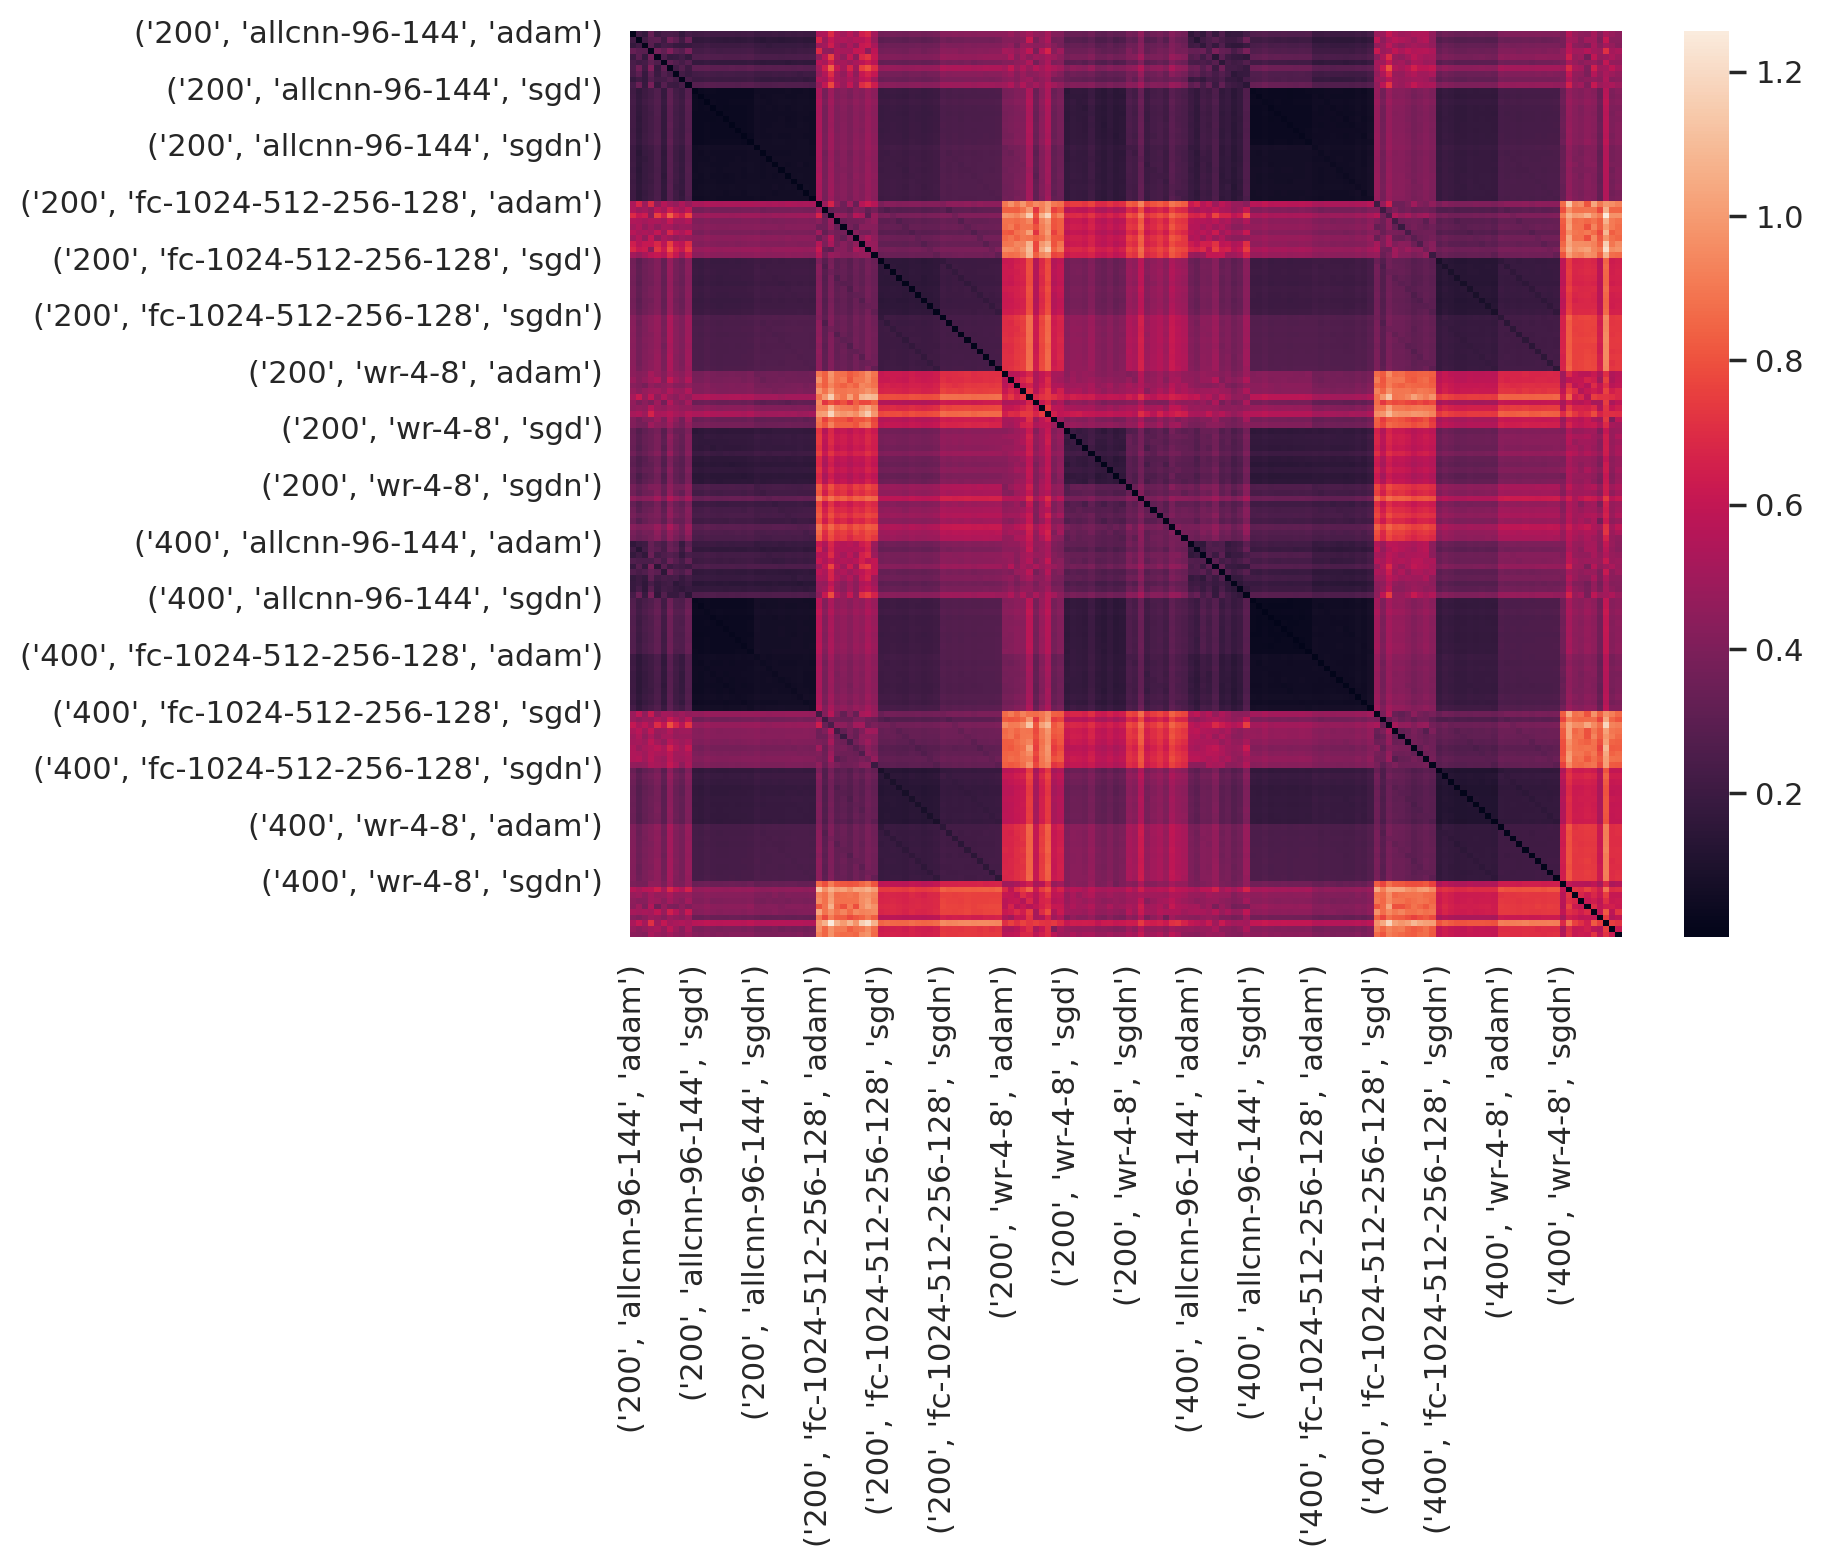

In [126]:
plot_pairwise_dist(dists, configs, conds={-1:list(range(42,52))})

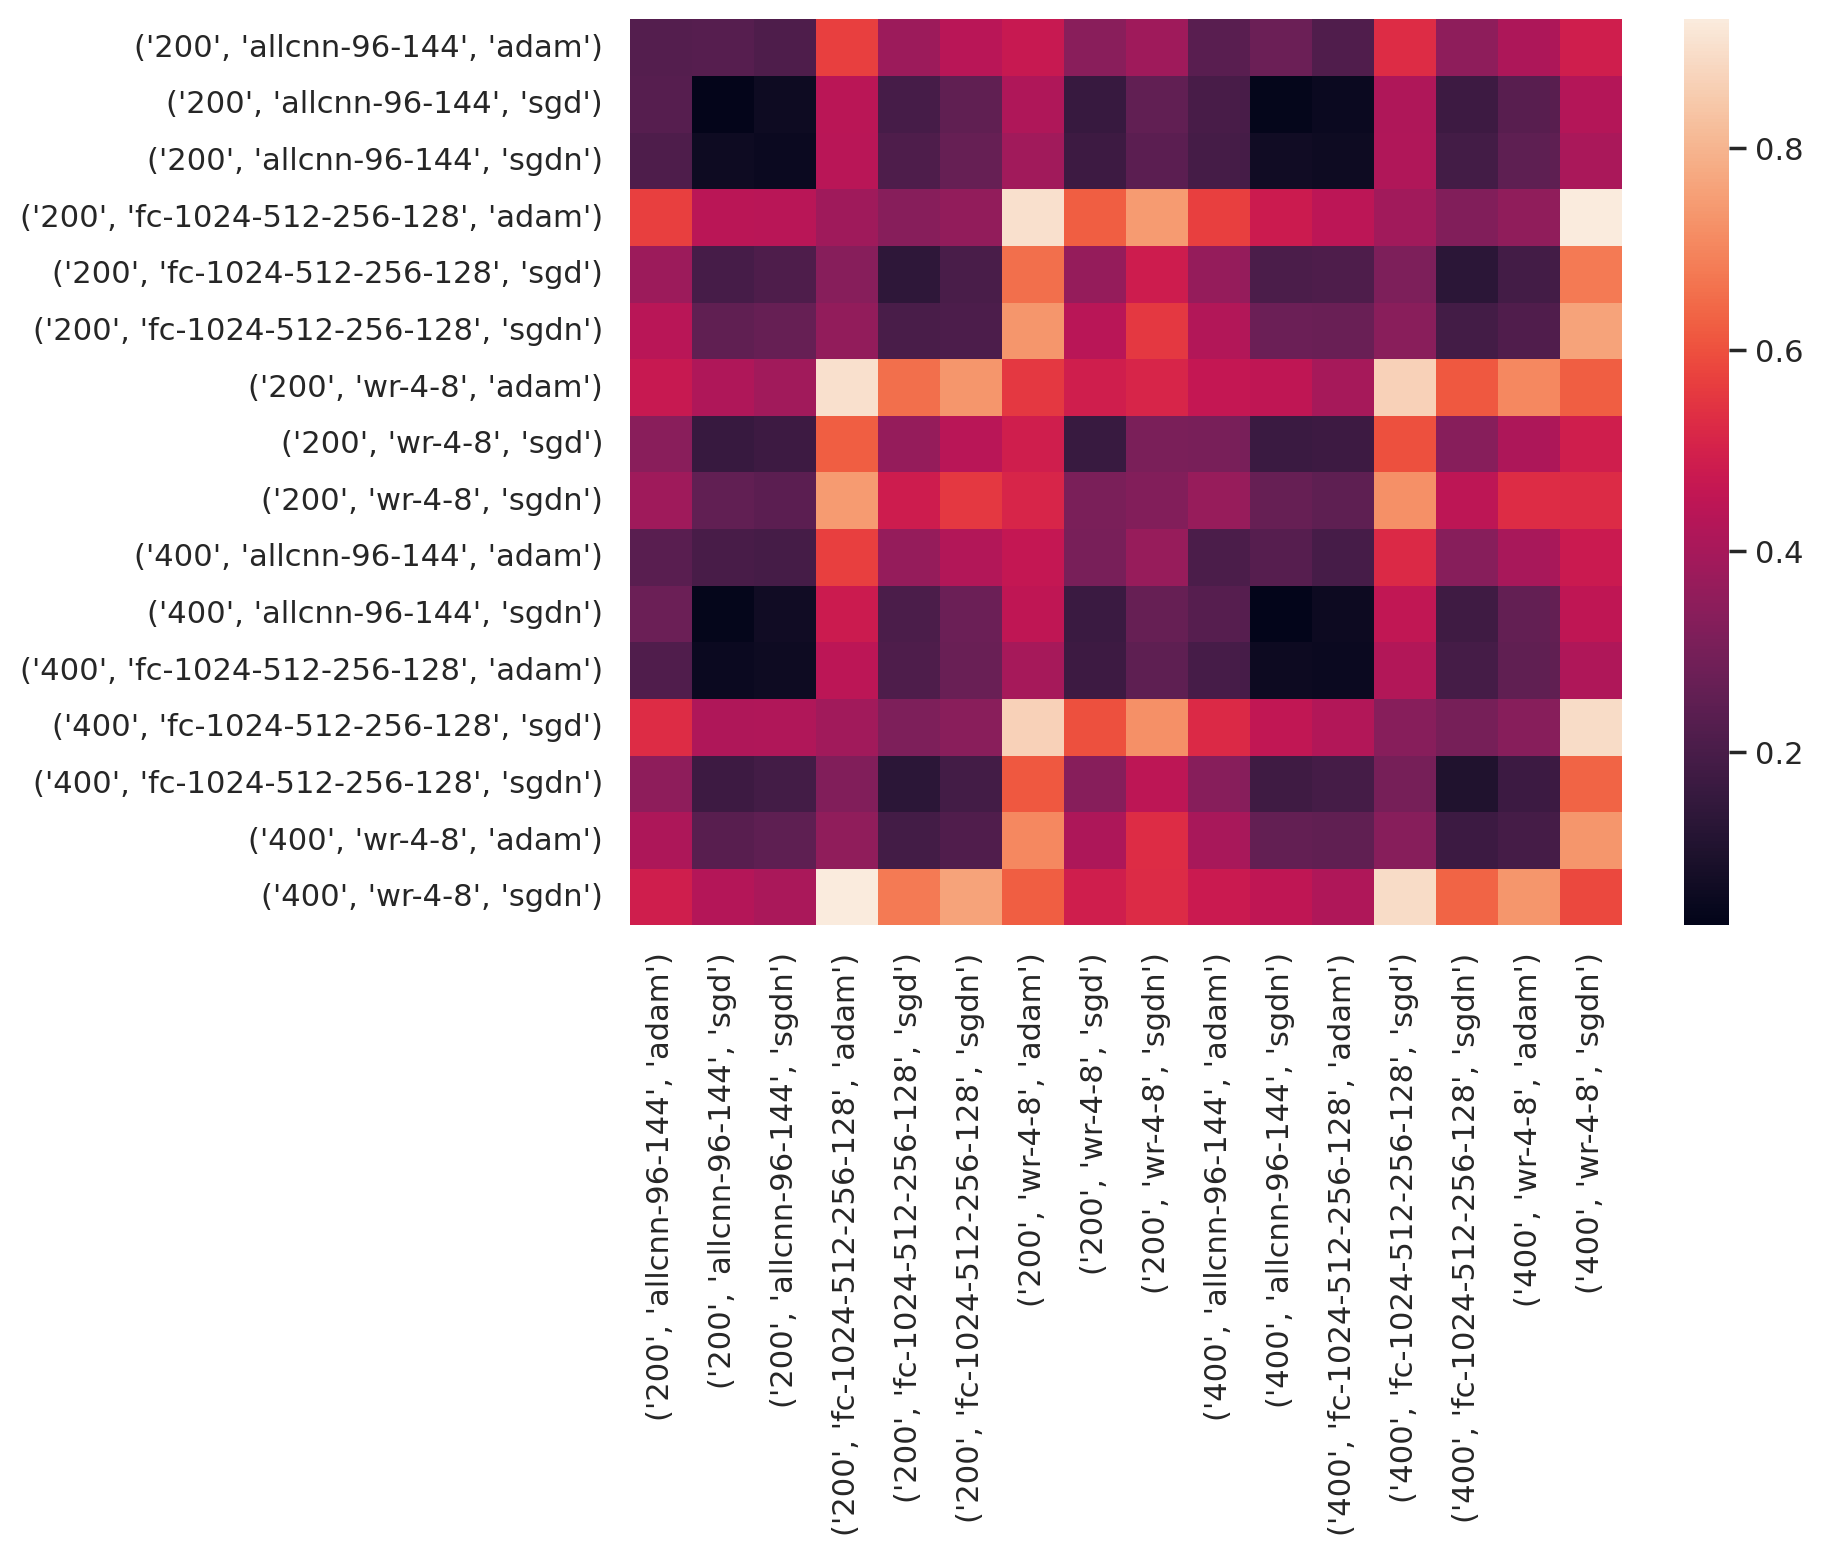

In [130]:
plot_pairwise_dist(dists, configs, conds={-1:list(range(42,52))}, mean=True)

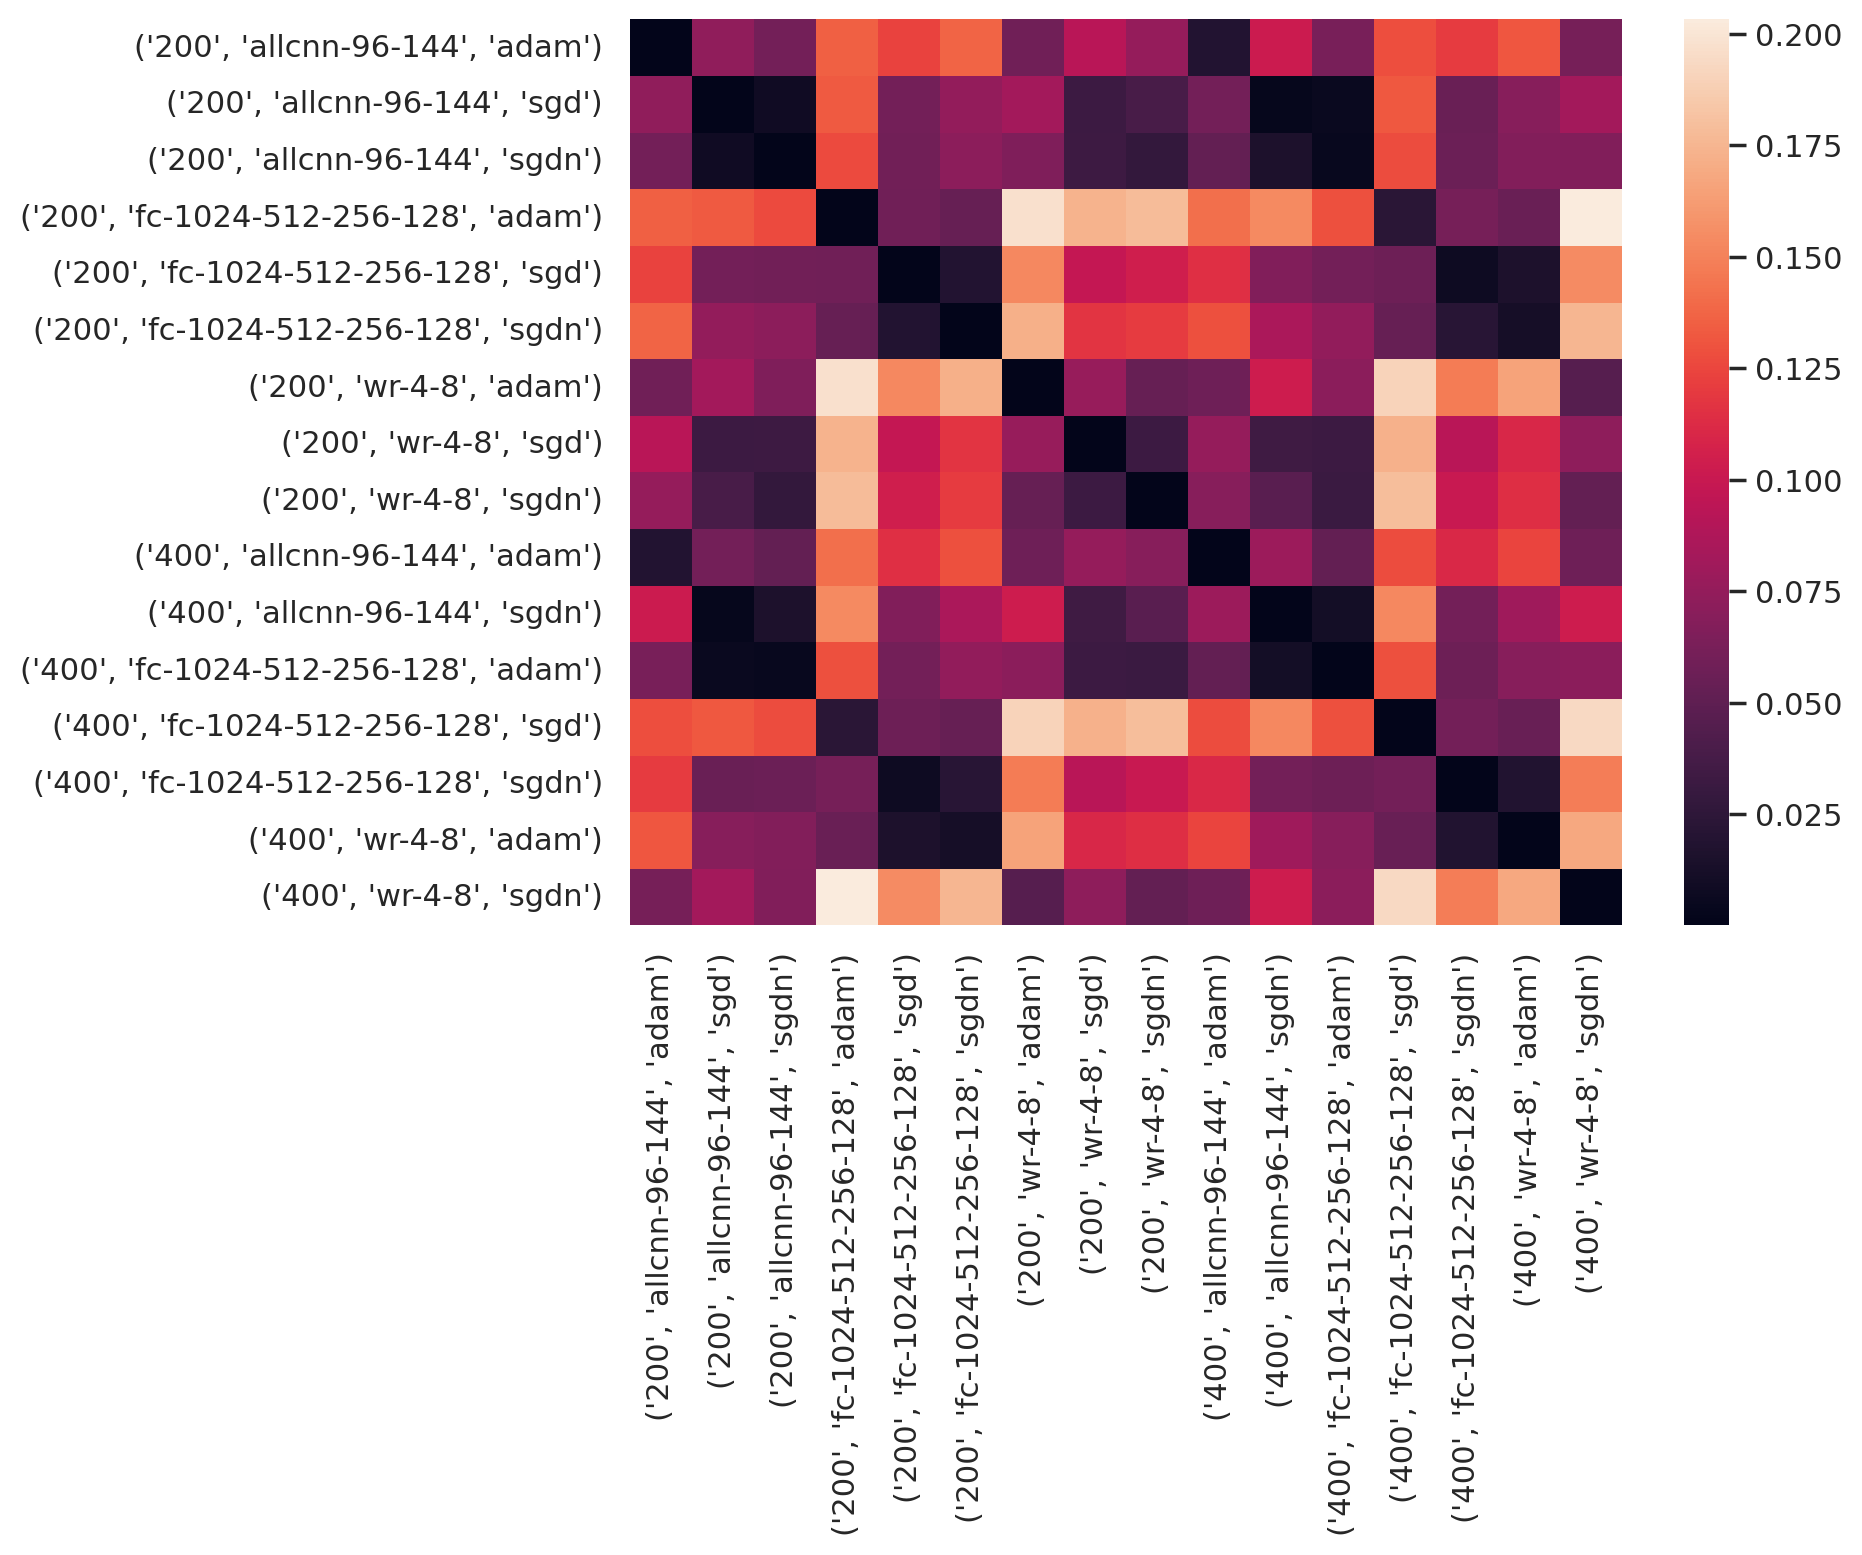

In [133]:
plot_pairwise_dist(dists, configs, conds={-1:[-1]}, block_size=1)